<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/Chapter09/Detectron2_Chapter09_UsingExistingAugmentations.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 09 - Using Existing Augmentations



## Installation

In [ ]:
!python -m  pip install --q \
'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 9.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


## Datasets

In [ ]:
!wget -q https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/braintumors_coco.zip
!unzip -q braintumors_coco.zip

In [ ]:
import torch
from detectron2.utils.logger import setup_logger
logger = setup_logger()
from detectron2.data.datasets import register_coco_instances

In [ ]:
# Some configurations
name_ds = "braintumors_coco"
name_ds_train = name_ds + "_train"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_test = name_ds + "/test"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af
json_file_test = name_ds + "/test/" + af

In [ ]:
# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )
## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )


## Training configuration

In [ ]:
import os
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle

In [ ]:
output_dir = "output/object_detector_existing_augs"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
nc = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
# Select a model
config_file_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [ ]:
# Create a configuration file
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Download weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Set datasets
cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_test,)
# Workers
cfg.DATALOADER.NUM_WORKERS = 4
# Solver
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.STEPS = (5000, 7000)
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.NESTROV = False
cfg.SOLVER.MAX_ITER = 10000
# checkpoint
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
# anchors
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[68.33245953, 112.91302277,  89.55701886, 144.71037342,  47.77637482]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.99819939, 0.78726896, 1.23598428]]
# pixels
cfg.MODEL.PIXEL_MEAN = [20.1962, 20.1962, 20.1962]
cfg.MODEL.PIXEL_STD = [39.5985, 39.5985, 39.5985]

# Evaluation
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD
# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir

In [ ]:
# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

## Training

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
from detectron2.data import build_detection_train_loader

class MyTrainer(DefaultTrainer):
  @classmethod
  def build_train_loader(cls, cfg):
    augs = []
    # Aug 1: Add RandomBrightness with 50% chance
    augs.append(
        T.RandomApply(
          T.RandomBrightness(
              intensity_min = 0.5,
              intensity_max = 1.5),
          prob = 0.5
        ))

    # Aug 2: Add ResizeShortestEdge
    min_size = cfg.INPUT.MIN_SIZE_TRAIN
    max_size = cfg.INPUT.MAX_SIZE_TRAIN
    sample_style = cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
    augs.append(T.ResizeShortestEdge(
            min_size, 
            max_size, 
            sample_style)
        )

    # Aug 3: Add RandomFlipping
    if cfg.INPUT.RANDOM_FLIP != "none":
      augs.append(T.RandomFlip(
          horizontal=cfg.INPUT.RANDOM_FLIP == "horizontal",
          vertical=cfg.INPUT.RANDOM_FLIP == "vertical",
        )
      )

    mapper = DatasetMapper(cfg, 
                           is_train       = True, 
                           augmentations  = augs)
    return build_detection_train_loader(cfg, mapper=mapper)


In [ ]:
from detectron2.engine.hooks import HookBase
import torch
import logging

class BestModelHook(HookBase):
  def __init__(self, cfg, metric="bbox/AP50", min_max="max"):
    self._period = cfg.TEST.EVAL_PERIOD
    self.metric = metric
    self.min_max = min_max
    self.best_value = float("-inf") if min_max == "max" else float("inf")
    logger = logging.getLogger("detectron2")
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    self._logger = logger
        

  def _take_latest_metrics(self):
    with torch.no_grad():
      latest_metrics = self.trainer.storage.latest()
      return latest_metrics
      
  def after_step(self):
    next_iter = self.trainer.iter + 1
    is_final = next_iter == self.trainer.max_iter
    if is_final or (self._period > 0 and next_iter % self._period == 0):
      latest_metrics = self._take_latest_metrics()
      for (key, (value, iter)) in latest_metrics.items():
        if key == self.metric:
          if (self.min_max == "min" and value < self.best_value) or (self.min_max == "max" and value > self.best_value):
            self._logger.info("Updating best model at iteration {} with {} = {}".format(iter, self.metric, value))
            self.best_value = value
            self.trainer.checkpointer.save("model_best")
            

In [ ]:
trainer = MyTrainer(cfg)
bm_hook = BestModelHook(cfg, metric="bbox/AP50", min_max="max")
trainer.register_hooks(hooks=[bm_hook])

[02/15 17:56:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

def imshow(image):
  dpi = plt.rcParams["figure.dpi"]
  im_data = image[:,:, ::-1]
  height, width, depth = im_data.shape
  figsize = width / float(dpi), height / float(dpi)
  fig = plt.figure(figsize=figsize)
  plt.imshow(im_data)
  plt.imshow(im_data)
  plt.axis("off")
  plt.show()

def visualize_image_boxes(img, boxes, colors=['b']):
  v = Visualizer(img, metadata={})
  v = v.overlay_instances(
      boxes=boxes, 
      assigned_colors=colors*len(boxes)
      )
  im_data = v.get_image()
  imshow(im_data)
  
def visualize_sample(sample):
  img = sample['image'].to("cpu").numpy()
  img = np.moveaxis(img, 0, -1)
  boxes = sample['instances'].get('gt_boxes')
  visualize_image_boxes(img, boxes)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


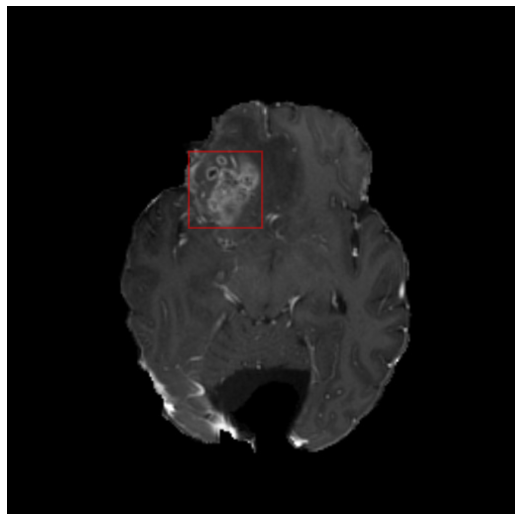

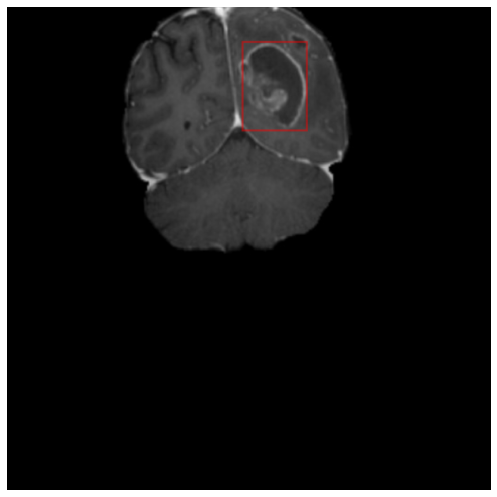

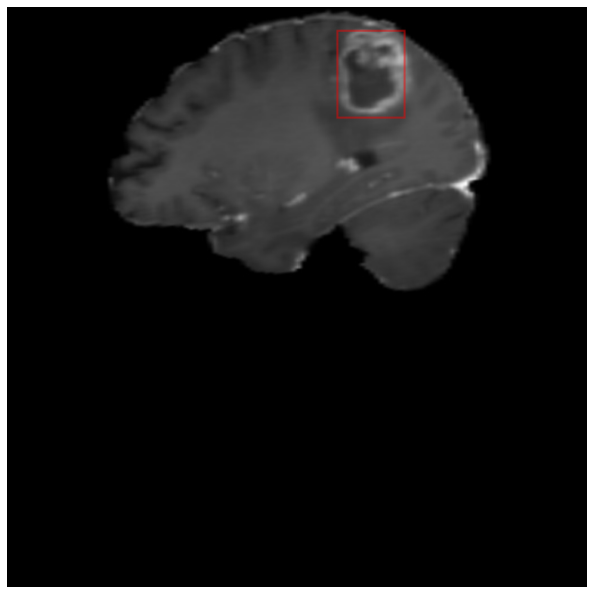

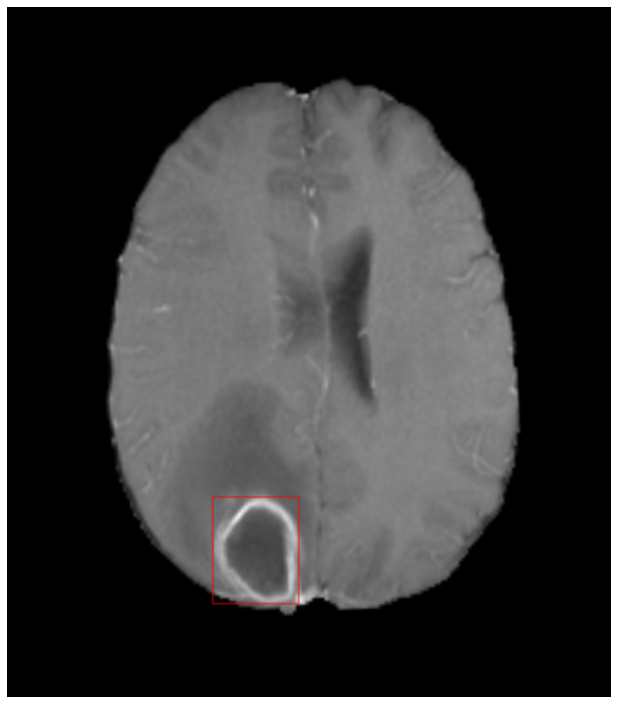

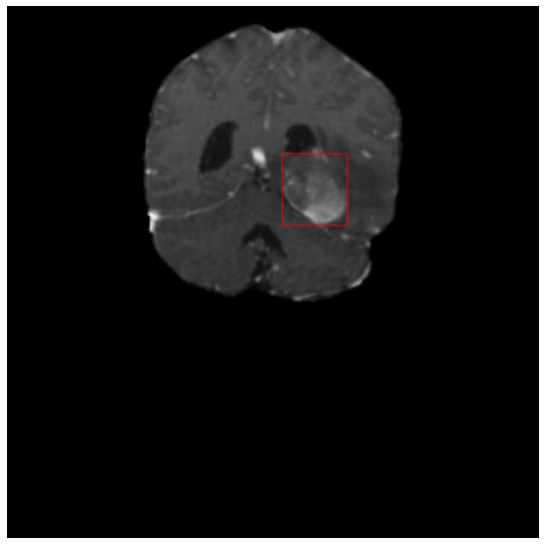

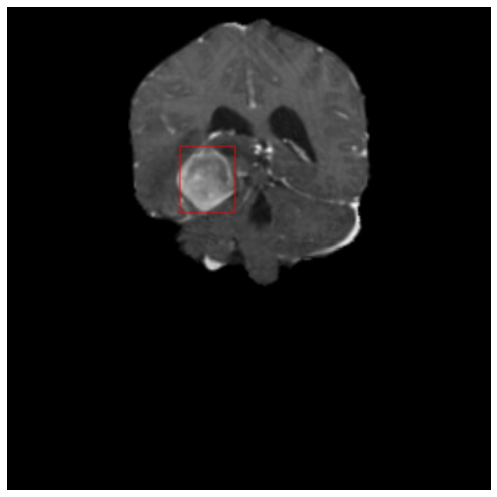

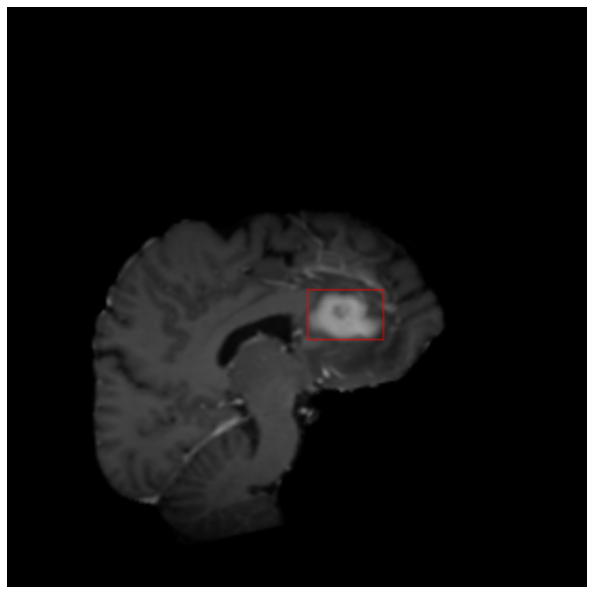

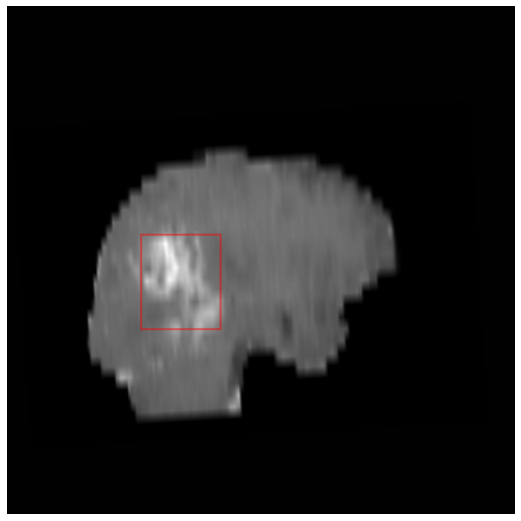

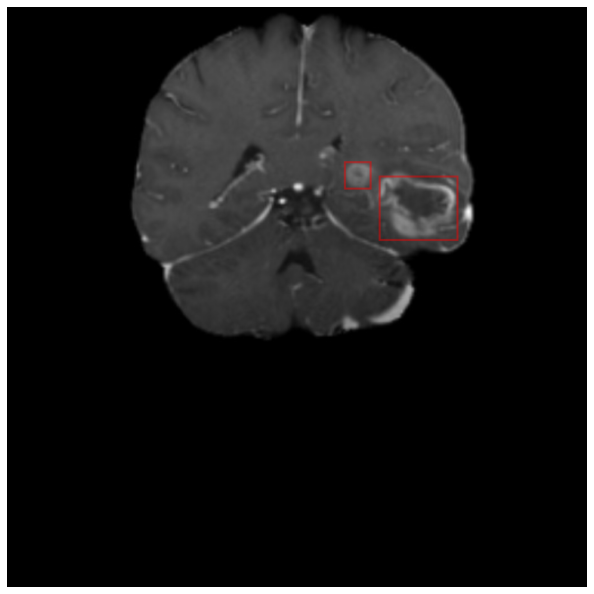

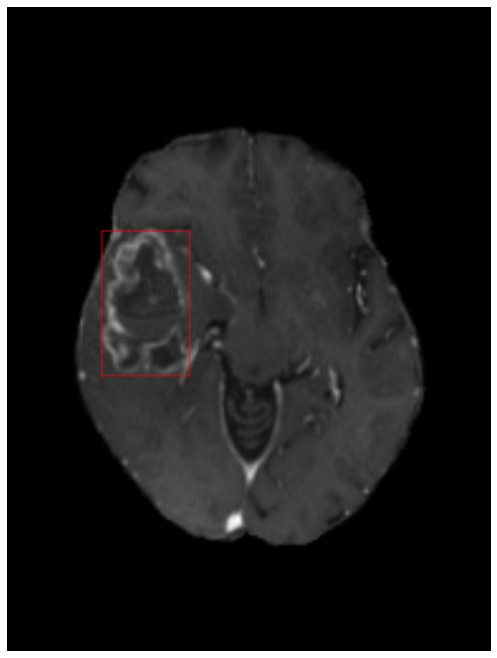

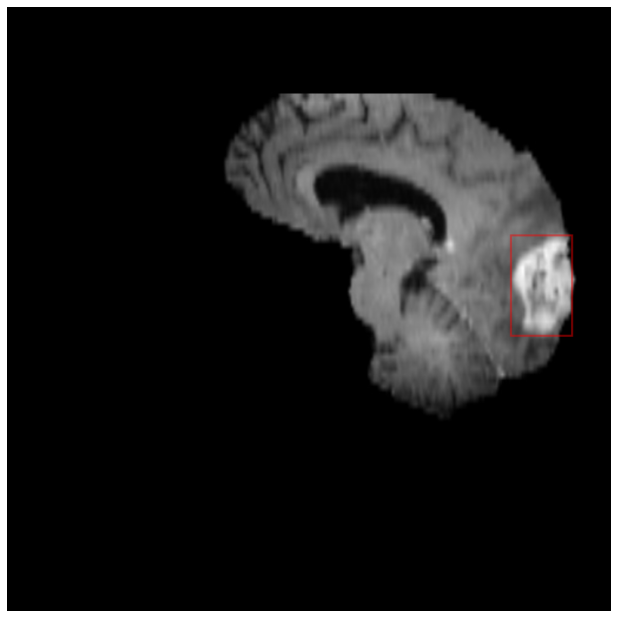

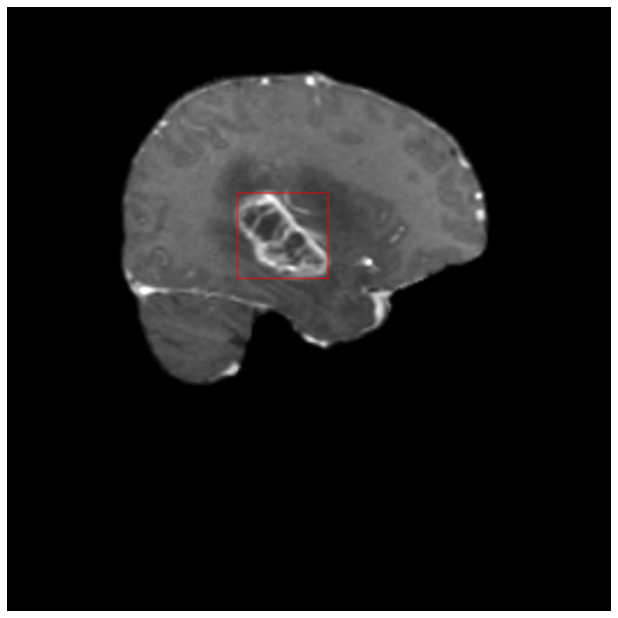

In [ ]:
# display 2 training batch
import numpy as np
tli = iter(trainer.data_loader)
for i in range(2):
  batch = next(tli)
  for sample in batch:
    visualize_sample(sample)

In [ ]:
import gc
gc.collect()

51113

In [29]:
trainer.train()

## Keep only best model and remove all others

In [ ]:
import os
from glob import glob
files = glob(os.path.join(cfg.OUTPUT_DIR, "*.pth"))
for f in files:
  if f != os.path.join(cfg.OUTPUT_DIR, "model_best.pth"):
    os.remove(f)

## Download training results

In [ ]:
# workaround if the next cell brings locale error
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# zip
!zip -r {cfg.OUTPUT_DIR}.zip {cfg.OUTPUT_DIR}
from google.colab import files
files.download(cfg.OUTPUT_DIR+".zip")

  adding: output/object_detector_augs/ (stored 0%)
  adding: output/object_detector_augs/events.out.tfevents.1673238714.e3d6e8c258a8.708.0 (deflated 72%)
  adding: output/object_detector_augs/cfg.pickle (deflated 50%)
  adding: output/object_detector_augs/metrics.json (deflated 78%)
  adding: output/object_detector_augs/coco_instances_results.json (deflated 70%)
  adding: output/object_detector_augs/last_checkpoint (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>